# Approach

In this notebook, I view the TCGA data using PCA and UMAP to search for obvious clustering. Spoiler alert: There ain't any!

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import umap

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

Load the data (in the future, I should write a function to do this automatically...)

In [26]:
df = pd.read_csv('../luminalAB/mrna/trimmedTMM.csv', index_col='geneid')
logdf = pd.read_csv('../luminalAB/mrna/logTMM.csv', index_col='geneid')
scaled = pd.read_csv('../luminalAB/mrna/NormalizedlogTMM.csv', index_col='geneid')
meta = pd.read_csv('../luminalAB/mrna/lumAB_id_cancer.txt', sep='\t')
meta.ID = meta.ID.astype('category')
meta.ID.cat.set_categories(df.columns, inplace=True)
meta.sort_values("ID", inplace=True)

# PCA

Let's view the data by PCA, using the log-transformed and standardized-log-transformed data (henceforth: scaled). PCA often doesn't work great with large numbers of points unless the clusters are pretty separated relative to the total noise, but who knows...

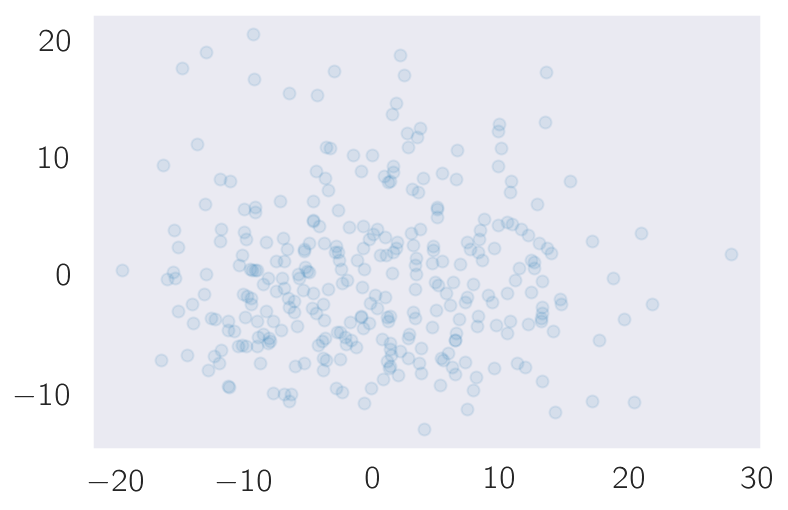

In [10]:
pca = PCA(2)
coords = pca.fit_transform(logdf.T)
pca.explained_variance_ratio_
plt.scatter(*coords.T, alpha=0.1)

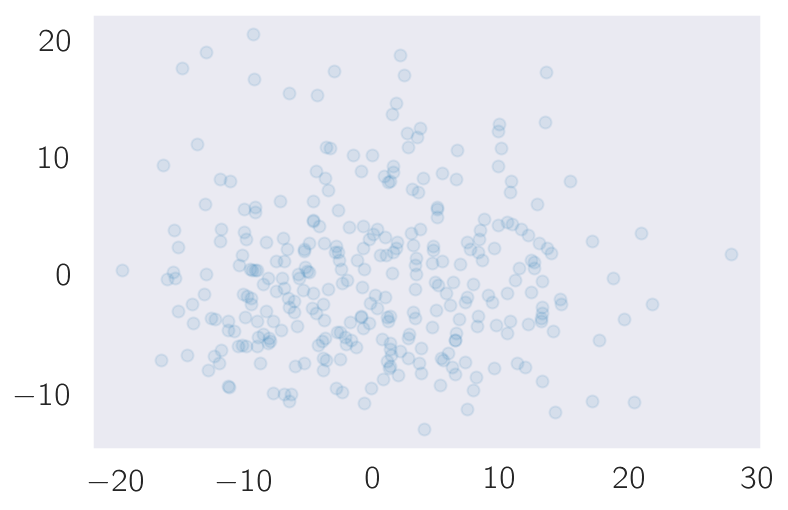

In [11]:
pca2 = PCA(2)
coords2 = pca2.fit_transform(scaled.T)
pca2.explained_variance_ratio_
plt.scatter(*coords.T, alpha=0.1)

No clusters are visible by PCA. Better luck next time! Yeah, I know my axes are not labeled, and there is no percentage of variance explained, but the lack of clusters makes the extra effort not worth it.

# UMAP

Maybe what is happening is that the clusters are relatively close together, and PCA is reflecting that the within cluster variance $\sim$ between cluster variance. Tools such as t-SNE and UMAP are often better in these cases. Let's try and see if those work:

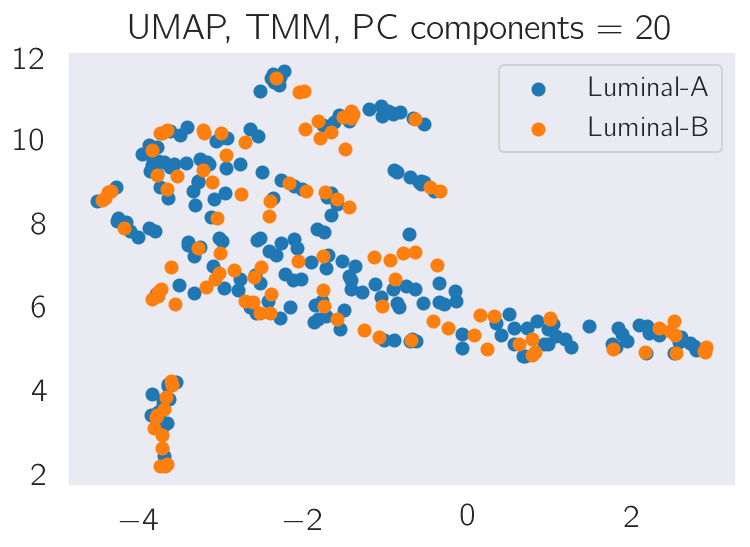

In [22]:
def plot_UMAP(data, title, meta=meta, pc_comps=15, **kwargs):
    """
    Plot a UMAP of the desired data

    Params:
    data:    pd.DataFrame. Data to plot
    meta:    pd.DataFrame. Contains labels to color data by.
    pc_comps:    int. Number of principal components to keep
    kwarsg:    params to pass to umap.UMAP()
    
    Out:
    UMAP Plot
    """
    pca = PCA(pc_comps)
    coords = pca.fit_transform(data.T)

    fit = umap.UMAP(**kwargs)
    u = fit.fit_transform(coords)

    for name, group in meta.groupby('cancer'):
        idx = group.index.values
        plt.scatter(*u[idx].T, label=name.replace('_', '-'))
    plt.legend()
    plt.title(title)

plot_UMAP(df, 'UMAP, TMM, PC components = 20')

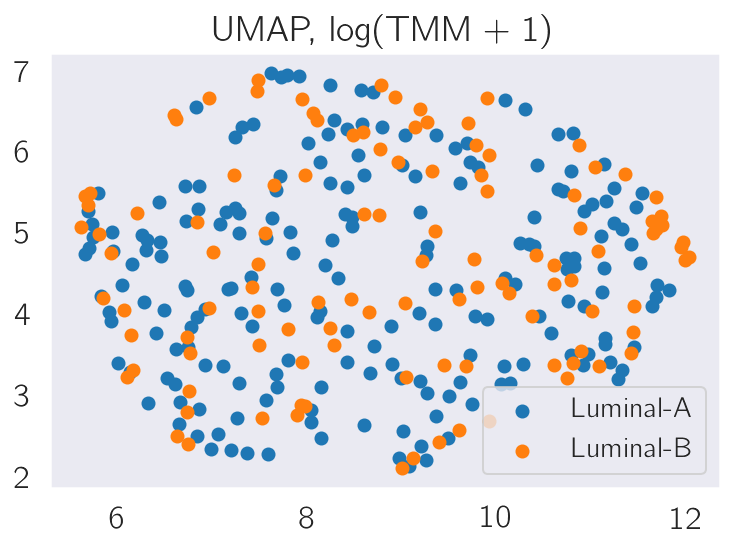

In [23]:
plot_UMAP(logdf, 'UMAP, log(TMM + 1)')

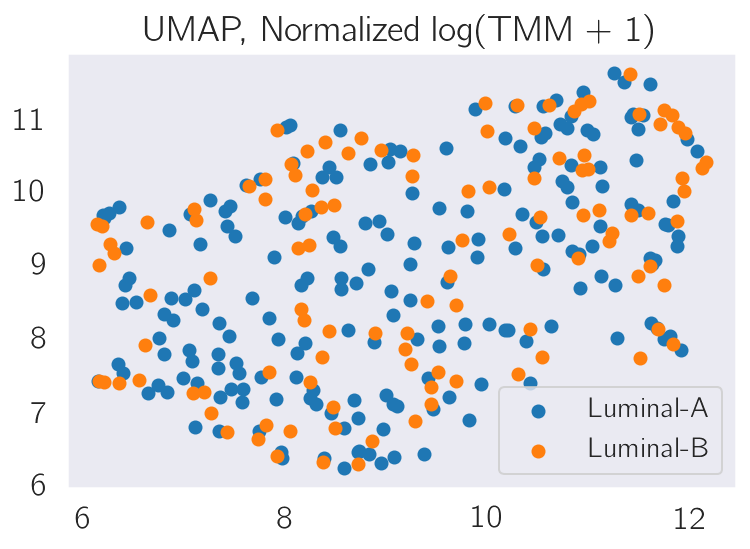

In [24]:
plot_UMAP(scaled, 'UMAP, Normalized log(TMM + 1)')

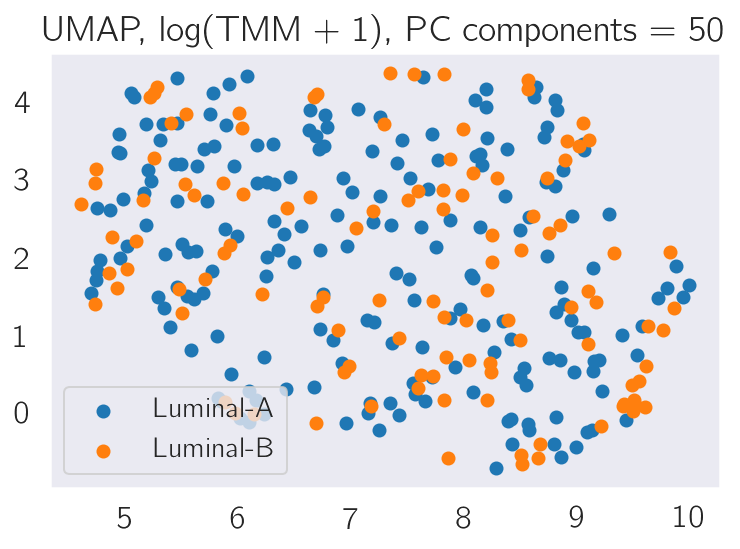

In [25]:
plot_UMAP(logdf, 'UMAP, log(TMM + 1), PC components = 50', pc_comps=50)

Nope! This likely means that if there *is* a difference between Luminal A and Luminal B cancer types, the difference is subtle at best.